In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, cohen_kappa_score
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch as th
torch. __version__

'1.8.1+cu101'

In [ ]:
import torchvision
torchvision. __version__

'0.9.1+cu101'

In [ ]:
import sklearn
sklearn. __version__

'0.22.2.post1'

In [ ]:
!unzip '/content/drive/MyDrive/covid-19/covid-19-bulk.zip'

Streaming output truncated to the last 5000 lines.
  inflating: covid-19-bulk/train/covid/COVID-2805.png  
  inflating: covid-19-bulk/train/covid/COVID-2806.png  
  inflating: covid-19-bulk/train/covid/COVID-2807.png  
  inflating: covid-19-bulk/train/covid/COVID-2808.png  
  inflating: covid-19-bulk/train/covid/COVID-2809.png  
  inflating: covid-19-bulk/train/covid/COVID-281.png  
  inflating: covid-19-bulk/train/covid/COVID-2810.png  
  inflating: covid-19-bulk/train/covid/COVID-2811.png  
  inflating: covid-19-bulk/train/covid/COVID-2812.png  
  inflating: covid-19-bulk/train/covid/COVID-2813.png  
  inflating: covid-19-bulk/train/covid/COVID-2814.png  
  inflating: covid-19-bulk/train/covid/COVID-2815.png  
  inflating: covid-19-bulk/train/covid/COVID-2816.png  
  inflating: covid-19-bulk/train/covid/COVID-2817.png  
  inflating: covid-19-bulk/train/covid/COVID-2818.png  
  inflating: covid-19-bulk/train/covid/COVID-2819.png  
  inflating: covid-19-bulk/train/covid/COVID-282.png  

In [ ]:
%cd 


[Errno 2] No such file or directory: 'Mycovid/'
/content


In [ ]:
DATA_PATH = '/content/covid-19-bulk/train'

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(p=0.4),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), 
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [ ]:
import numpy as np


In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train'])
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid', 'normal']


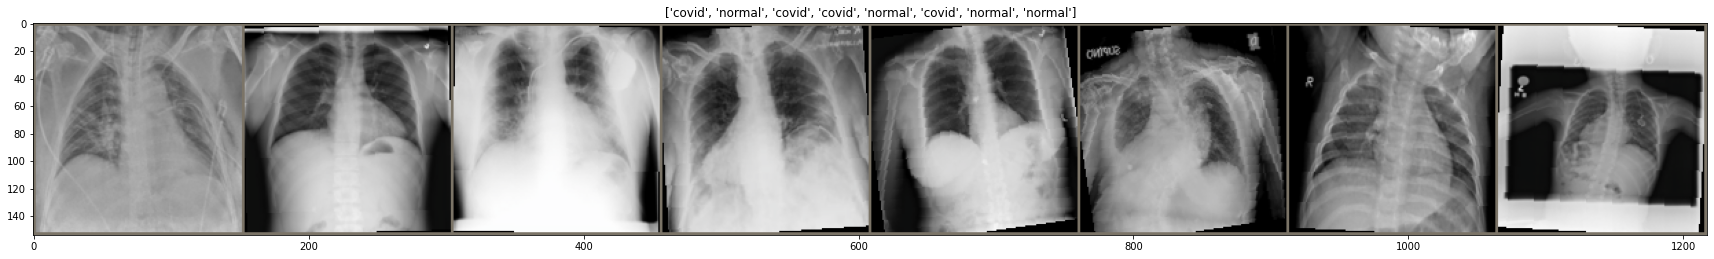

In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6955906


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
import imagesize

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)


Epoch 1/50
----------


train Loss: 0.5355 | train Accuracy: 0.7981


val Loss: 0.4861 | val Accuracy: 0.8157 | Kappa Score: 0.6227
Val loss Decreased from inf to 0.4861 
Saving Weights... 

Epoch 2/50
----------


train Loss: 0.5139 | train Accuracy: 0.8021


val Loss: 0.4330 | val Accuracy: 0.8324 | Kappa Score: 0.6438
Val loss Decreased from 0.4861 to 0.4330 
Saving Weights... 

Epoch 3/50
----------


train Loss: 0.5127 | train Accuracy: 0.8096


val Loss: 0.4769 | val Accuracy: 0.8198 | Kappa Score: 0.6069

Epoch 4/50
----------


train Loss: 0.5088 | train Accuracy: 0.8050


val Loss: 0.4432 | val Accuracy: 0.8274 | Kappa Score: 0.6224

Epoch 5/50
----------


train Loss: 0.5292 | train Accuracy: 0.7977


val Loss: 0.4597 | val Accuracy: 0.8232 | Kappa Score: 0.6200

Epoch 6/50
----------


train Loss: 0.5388 | train Accuracy: 0.7996


val Loss: 0.4563 | val Accuracy: 0.8265 | Kappa Score: 0.6257

Epoch 7/50
----------


train Loss: 0.4917 | train Accuracy: 0.8108


val Loss: 0.5043 | val Accuracy: 0.8098 | Kappa Score: 0.5948

Epoch 8/50
----------


train Loss: 0.5011 | train Accuracy: 0.8063


val Loss: 0.4302 | val Accuracy: 0.8307 | Kappa Score: 0.6232
Val loss Decreased from 0.4330 to 0.4302 
Saving Weights... 

Epoch 9/50
----------


train Loss: 0.5040 | train Accuracy: 0.8090


val Loss: 0.4214 | val Accuracy: 0.8324 | Kappa Score: 0.6320
Val loss Decreased from 0.4302 to 0.4214 
Saving Weights... 

Epoch 10/50
----------


train Loss: 0.5171 | train Accuracy: 0.8040


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.4309 | val Accuracy: 0.8274 | Kappa Score: nan

Epoch 11/50
----------


train Loss: 0.5048 | train Accuracy: 0.8092


val Loss: 0.4228 | val Accuracy: 0.8324 | Kappa Score: 0.6351

Epoch 12/50
----------


train Loss: 0.5147 | train Accuracy: 0.8035


val Loss: 0.5028 | val Accuracy: 0.8165 | Kappa Score: 0.6111

Epoch 13/50
----------


train Loss: 0.5076 | train Accuracy: 0.8060


val Loss: 0.4142 | val Accuracy: 0.8324 | Kappa Score: 0.6309
Val loss Decreased from 0.4214 to 0.4142 
Saving Weights... 

Epoch 14/50
----------


train Loss: 0.5257 | train Accuracy: 0.7979


val Loss: 0.4051 | val Accuracy: 0.8382 | Kappa Score: nan
Val loss Decreased from 0.4142 to 0.4051 
Saving Weights... 

Epoch 15/50
----------


train Loss: 0.5135 | train Accuracy: 0.8015


val Loss: 0.5302 | val Accuracy: 0.8040 | Kappa Score: 0.5820

Epoch 16/50
----------


train Loss: 0.5167 | train Accuracy: 0.8071


val Loss: 0.4247 | val Accuracy: 0.8290 | Kappa Score: nan

Epoch 17/50
----------


train Loss: 0.5038 | train Accuracy: 0.8040


val Loss: 0.4145 | val Accuracy: 0.8332 | Kappa Score: 0.6436

Epoch 18/50
----------


train Loss: 0.5042 | train Accuracy: 0.8071


val Loss: 0.4464 | val Accuracy: 0.8274 | Kappa Score: 0.6189

Epoch 19/50
----------


train Loss: 0.5023 | train Accuracy: 0.8081


val Loss: 0.4243 | val Accuracy: 0.8315 | Kappa Score: nan

Epoch 20/50
----------


train Loss: 0.5137 | train Accuracy: 0.8050


val Loss: 0.4395 | val Accuracy: 0.8290 | Kappa Score: 0.6399

Epoch 21/50
----------


train Loss: 0.5066 | train Accuracy: 0.8125


val Loss: 0.4337 | val Accuracy: 0.8232 | Kappa Score: nan

Epoch 22/50
----------


train Loss: 0.5169 | train Accuracy: 0.8058


val Loss: 0.4913 | val Accuracy: 0.8148 | Kappa Score: 0.6102

Epoch 23/50
----------


train Loss: 0.5121 | train Accuracy: 0.8025


val Loss: 0.5132 | val Accuracy: 0.8157 | Kappa Score: nan

Epoch 24/50
----------


train Loss: 0.5090 | train Accuracy: 0.8038


val Loss: 0.4813 | val Accuracy: 0.8190 | Kappa Score: nan

Epoch 25/50
----------


train Loss: 0.5063 | train Accuracy: 0.8054


val Loss: 0.4233 | val Accuracy: 0.8315 | Kappa Score: nan

Epoch 26/50
----------


train Loss: 0.5336 | train Accuracy: 0.7935


val Loss: 0.4179 | val Accuracy: 0.8290 | Kappa Score: nan

Epoch 27/50
----------


train Loss: 0.5123 | train Accuracy: 0.8044


val Loss: 0.4736 | val Accuracy: 0.8182 | Kappa Score: nan

Epoch 28/50
----------


train Loss: 0.5234 | train Accuracy: 0.8000


val Loss: 0.4034 | val Accuracy: 0.8424 | Kappa Score: 0.6462
Val loss Decreased from 0.4051 to 0.4034 
Saving Weights... 

Epoch 29/50
----------


train Loss: 0.5438 | train Accuracy: 0.7952


val Loss: 0.4176 | val Accuracy: 0.8307 | Kappa Score: 0.6200

Epoch 30/50
----------


train Loss: 0.5073 | train Accuracy: 0.8050


val Loss: 0.4818 | val Accuracy: 0.8165 | Kappa Score: 0.5998

Epoch 31/50
----------


train Loss: 0.5181 | train Accuracy: 0.8010


val Loss: 0.4296 | val Accuracy: 0.8307 | Kappa Score: 0.6387

Epoch 32/50
----------


train Loss: 0.5361 | train Accuracy: 0.8019


val Loss: 0.4852 | val Accuracy: 0.8198 | Kappa Score: 0.6185

Epoch 33/50
----------


train Loss: 0.5066 | train Accuracy: 0.8077


val Loss: 0.4129 | val Accuracy: 0.8324 | Kappa Score: 0.6187

Epoch 34/50
----------


train Loss: 0.5215 | train Accuracy: 0.8013


val Loss: 0.4408 | val Accuracy: 0.8307 | Kappa Score: 0.6366

Epoch 35/50
----------


train Loss: 0.5173 | train Accuracy: 0.8044


val Loss: 0.4448 | val Accuracy: 0.8249 | Kappa Score: 0.6266

Epoch 36/50
----------


train Loss: 0.5124 | train Accuracy: 0.8050


val Loss: 0.4341 | val Accuracy: 0.8332 | Kappa Score: 0.6310

Epoch 37/50
----------


train Loss: 0.5041 | train Accuracy: 0.8083


val Loss: 0.4115 | val Accuracy: 0.8315 | Kappa Score: nan

Epoch 38/50
----------


train Loss: 0.5213 | train Accuracy: 0.8067


val Loss: 0.4164 | val Accuracy: 0.8365 | Kappa Score: 0.6247

Epoch 39/50
----------


train Loss: 0.5263 | train Accuracy: 0.8015


val Loss: 0.4140 | val Accuracy: 0.8324 | Kappa Score: 0.6451

Epoch 40/50
----------


train Loss: 0.5187 | train Accuracy: 0.8004


val Loss: 0.4800 | val Accuracy: 0.8240 | Kappa Score: 0.6211

Epoch 41/50
----------


train Loss: 0.5050 | train Accuracy: 0.8079


val Loss: 0.4155 | val Accuracy: 0.8340 | Kappa Score: 0.6404

Epoch 42/50
----------


train Loss: 0.5243 | train Accuracy: 0.8029


val Loss: 0.4151 | val Accuracy: 0.8332 | Kappa Score: nan

Epoch 43/50
----------


train Loss: 0.5079 | train Accuracy: 0.8085


val Loss: 0.4366 | val Accuracy: 0.8274 | Kappa Score: 0.6215

Epoch 44/50
----------


train Loss: 0.5063 | train Accuracy: 0.8096


val Loss: 0.4100 | val Accuracy: 0.8307 | Kappa Score: nan

Epoch 45/50
----------


train Loss: 0.5072 | train Accuracy: 0.8108


val Loss: 0.4375 | val Accuracy: 0.8299 | Kappa Score: nan

Epoch 46/50
----------


train Loss: 0.5227 | train Accuracy: 0.8038


val Loss: 0.4654 | val Accuracy: 0.8165 | Kappa Score: 0.6125

Epoch 47/50
----------


train Loss: 0.4949 | train Accuracy: 0.8069


val Loss: 0.4583 | val Accuracy: 0.8232 | Kappa Score: 0.6189

Epoch 48/50
----------


train Loss: 0.5062 | train Accuracy: 0.8035


val Loss: 0.4336 | val Accuracy: 0.8265 | Kappa Score: nan

Epoch 49/50
----------


train Loss: 0.5257 | train Accuracy: 0.8033


val Loss: 0.4249 | val Accuracy: 0.8340 | Kappa Score: 0.6499

Epoch 50/50
----------


train Loss: 0.5210 | train Accuracy: 0.8025


val Loss: 0.4634 | val Accuracy: 0.8224 | Kappa Score: nan

Training complete in 57m 1s
Best val loss: 0.4034


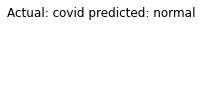

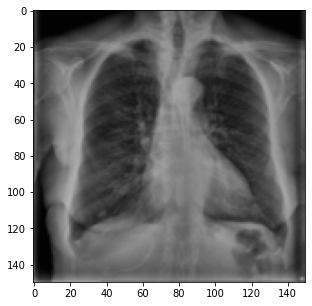

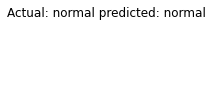

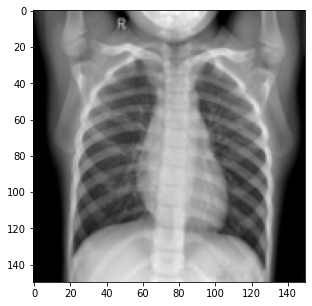

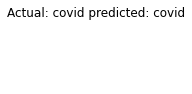

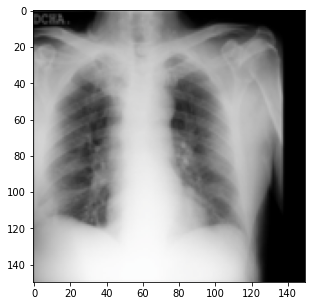

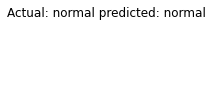

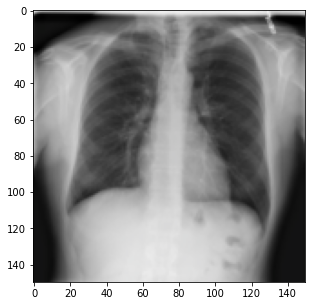

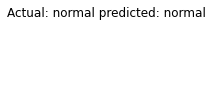

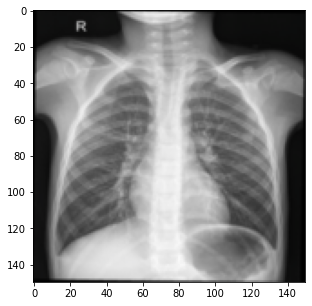

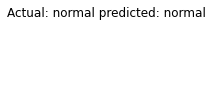

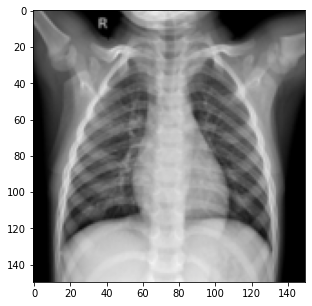

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
TEST_DATA_PATH = '/content/covid-19-bulk/test'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
model = base_model

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       116
           1       0.65      0.69      0.67       120

    accuracy                           0.65       236
   macro avg       0.65      0.65      0.65       236
weighted avg       0.65      0.65      0.65       236



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

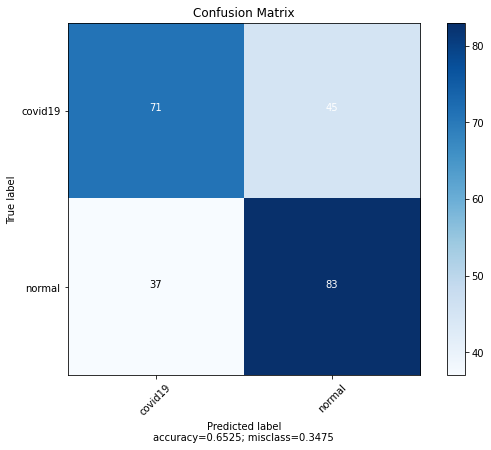

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [ ]:
torch.save(base_model.state_dict(), '/content/drive/MyDrive/yolov5 weigths/Helmet yolov5 /densenet_covid_model.pt')

In [ ]:
# Loading the model pre-trained weights from saved file
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('/content/drive/MyDrive/TM videos/densenet_covid_model.pt', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [ ]:
import cv2
from torch.autograd import Variable

In [ ]:
#Inference


def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

In [ ]:
predict('/content/drive/MyDrive/covid-19/covid-19/53EC07C9-5CC6-4BE4-9B6F-D7B0D72AAA7E.jpeg')

NameError: ignored